# Brain MRI - Image Segmentation
------

Image Segmentation is a technique often implemented in medical analysis, where it is imported to know which pixel belongs to which class. In Image Segmentation a pixel-wise classification is performed. The goal of this pixel-wise classification is that each pixel regions share characteristics i.e. in autnomous driving this could be buildings or pedestrians [(Wikipedia, n.d.)](https://en.wikipedia.org/wiki/Image_segmentation#Classes_of_Segmentation_Techniques). 
My use-case belongs to semantic segmentation, where I try to segment a tumors from MRI scans of brains.

Dataset used: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

In [1]:
import os
import PIL
import numpy as np
np.random.seed(10)
import pandas as pd
from tqdm.notebook import tqdm
import math

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from scipy.spatial.distance import cdist

import torchvision.transforms.functional as F
from torchvision import transforms as transforms
import torch.nn as nn
import torch
from torchsummary import summary
from torch.utils.data import WeightedRandomSampler
from torchvision.utils import make_grid
from torchvision.utils import draw_segmentation_masks

from imgseg import (show, plot_random_masked_images, 
                    plot_one_image_mask, visualize_overlaps, 
                    plot_train_val_loss, loss_sma)
from imgseg import DoubleConvLayer, UNet4, UNet3
from imgseg import get_dataloader, SegmentationDataset
from imgseg import ModelInterface
from imgseg import DiceLoss

ModuleNotFoundError: No module named 'seaborn'

## Create Folder, Organize Data

Create folder structure from input images.

In [ ]:
if not os.path.isdir('./kaggle_3m/images'):
    os.mkdir('./kaggle_3m/images')
if not os.path.isdir('./kaggle_3m/masks'):
    os.mkdir('./kaggle_3m/masks')

In [ ]:
all_images = []
def unpack_folder(path: str):
    """Unpacks folder recusrively and appends to global list."""
    files = os.listdir(path)
    for f in files:
        if '.tif' in f:
            all_images.append(os.path.join(path, f))
        elif os.path.isdir(os.path.join(path, f)):
            unpack_folder(os.path.join(path, f)) 

In [ ]:
unpack_folder('kaggle_3m/')
all_images[:5]

In [ ]:
REPLACE_FILES = False
new_path_images = './kaggle_3m/images/'
new_path_masks = './kaggle_3m/masks/'

if REPLACE_FILES:
    for file in tqdm(all_images):
        img = Image.open(file)
        name = os.path.split(file)[-1]
        if 'mask' in name and name not in os.listdir(new_path_masks):
            img.save(os.path.join(new_path_masks, name))
        elif name not in os.listdir(new_path_images):
            img.save(os.path.join(new_path_images, name))

In [ ]:
# build pandas dataset linking each mask with the real image
all_images = os.listdir(new_path_images)
all_masks = os.listdir(new_path_masks)
identifier = [img.split('.')[0] for img in all_images]

In [ ]:
df_images = pd.DataFrame({'identifier': identifier, 'image': all_images})
df_masks = pd.DataFrame({'mask':all_masks})
df_masks['identifier'] = df_masks['mask'].apply(lambda x: x.split('_mask.tif')[0])
df = pd.merge(left=df_images, right=df_masks, on='identifier', how='inner')
df['patient_key'] = df['identifier'].apply(lambda x: '_'.join(x.split('_')[:-2]))

df.head(2)

In [ ]:
assert df.isnull().sum().sum() == 0

## Visualize Scans with Masks

In [ ]:
plot_random_masked_images(df, 20)

**Comment:**

The images show different MRI Scans of human brains. The scans differ in the recorded height of the head, because for each directory there was one recording of a brain, which corresponds to one patient. The folders contain height sequences of human brains with respective masks. Thus, the images where only analyzed and modelled based on single height sequences resulting in a 3D Image.

In [ ]:
plot_one_image_mask(df, 'TCGA_FG_7643_20021104_3.tif')

In [ ]:
plot_one_image_mask(df, 'TCGA_DU_6408_19860521_36.tif')

**Commnent:**

Here, we have a look on an image without a segmentation mask and one with segmenation mask. The segmentation masks are labelled with 0's representing no tumor (foreground) and 1's representing tumor.

In [ ]:
PREPARE_DF = False

if PREPARE_DF:
    def make_mask_label(img_path):
        img_path = os.path.join('./kaggle_3m/masks/', img_path)
        img = np.asarray(PIL.Image.open(img_path))
        return True if img.sum() > 0 else False 
    
    df['has_segment_mask'] = df['mask'].apply(make_mask_label)
    
    if SAVE_DF:
        df.to_csv('./kaggle_3m/image_data.csv', index=False)
        
else:
    df = pd.read_csv('./kaggle_3m/image_data.csv')

In [ ]:
df.head(2)

In [ ]:
p = sns.countplot(x=df['has_segment_mask'], palette='Paired')
p.set_title('Segmentation Masks available')
sns.despine()
plt.show()

**Comment:**

Our dataset consists mostly of images without tumors. These pictures can also belong to heights where no part of tumor was located. We have approx. half the amount of images with segmentation masks (tumors) than without segmentation masks and thus an unbalanced target variable.

In [ ]:
df.head(2)

In [ ]:
p = df['patient_key'].value_counts().plot(kind='kde', color='grey')
p.set_title('Distribution of Images per Patient')
p.set_xlim(0)
sns.despine()
plt.show()

The distributions of mri images per patient reaches from 20 to 90. Rightskewed distribution shows that we have more patients which tend to have less images available.

In [ ]:
BUILD_SET = False

if BUILD_SET:
    all_patients = np.unique(df['patient_key'])
    mean_images_per_patient = df['patient_key'].value_counts().mean()
    take_n_patients =  (df.shape[0] * .2) / mean_images_per_patient
    print('Patients for test set', int(take_n_patients))
    test_patients = np.random.choice(all_patients, size=22, replace=False)
    print('Images in test set', df[df['patient_key'].isin(test_patients)].shape[0])
    test = df[df['patient_key'].isin(test_patients)]
    train = df[~df['patient_key'].isin(test_patients)] 
    val, test = train_test_split(test, test_size=.5, random_state=10, stratify=test['has_segment_mask'])
    train['set'] = 'train'
    val['set'] = 'val'
    test['set'] = 'test'
    df = pd.concat([train, val, test], axis=0)
    df.to_csv('./kaggle_3m/image_data.csv', index=False)

In [ ]:
plt.subplots(figsize=(18, 4))

for i, set_idf in enumerate(df['set'].unique()):
    plt.subplot(1,3,i+1)
    p = df.loc[df['set'] == set_idf, 'has_segment_mask'].value_counts().plot(kind='bar', color='grey')
    sns.despine()
    p.set_title(f'Target distribution of {set_idf}')
    p.set_xlabel('has_segment_mask')
plt.show()

These are the distributions of the different test sets. The data split was made according to the evaluation criteria of how well the model performs on unseen patients scans. Therefore, the data was split over the different patient ID's. The distribution within each set look fairly similar to each other.

In [ ]:
# image dim
PIL.Image.open(os.path.join(new_path_images, 
                            df.loc[0, 'image'])).size

The images are dimensionend on 3x256x256 sized images.

## Model - U-Net

<img src="./doc/u-net-architecture.png" width=500 align="center">

The raw code of the U-Net implementation can be found in the folder `./imgseg/networks.py`. The U-Net architecture is a very famous network architecture when it comes to image segmenation. The name origins from the shape of network, where the decoder forms the left part of the U and the decoder the right part. In the middle there is the bottleneck of the network where the learned latent features from the decoder occur. Another important property of the architecture are the skip connections after each double convolutional layer, which feeds the decoder part with addtional information from the encoder. The skip connection also help to stabilize the training as the error will be propagated back over the skip connections. 
Next I describe, how my implementation differs from the proposed one in the paper of [(Ronneberger et al., 2015)](https://arxiv.org/abs/1505.04597):

- For some of the fitted models I used 3 skip connections rather than 4 to decrease model complexity. (7 Mio. Params vs 31 Mio. Params). I did this because my input images only consisten of 3x256x256  dimension whereas in the dimension in the paper were double the size. 
- Added padding of 1 in each Double Convolutional Layer to maintain the size over Double Conv layer. It makes it also possible to reproduce the same output dimensions with the decoder part of the network. Nevertheless, this increases the dimensionality of each feature map in the bottleneck as well. 
- Add batchnorm to each Double Conv Layer for a more stable training.
- Used one output activation map with sigmoid activations instead of the proposed two in the paper. In the paper they use two output feature maps representing once the segmentation for the foreground and once the one for the actual object.

In [ ]:
summary(DoubleConvLayer(1, 64), input_size=(1, 572, 572), device='cpu')

In [ ]:
summary(UNet3(in_channels=1, out_channels=1), input_size=(1, 256, 256), device='cpu')

In [ ]:
image, mask = df.loc[0, ['image', 'mask']].values

In [ ]:
image, mask

## Setup Dataloader

In [ ]:
image_transforms_inference = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
])

inverse_image_transforms = transforms.Compose([
    transforms.ToPILImage()
])

In [ ]:
dataloader = get_dataloader(image_dir='./kaggle_3m/images/', 
                            mask_dir='./kaggle_3m/masks/', 
                            df=pd.read_csv('./kaggle_3m/image_data.csv'), 
                            transformations=None,
                            batch_size=10, workers=1)

In [ ]:
img, seg = next(iter(dataloader))

In [ ]:
img.shape, seg.shape

## Augmentations

For my training I used techniques for augmentations: 
- RandomRotation
- RandomHorizontalFlip
- RandomVerticalFlip
- Resize

I focused on transformations which do not affect the actual image mask with respect to their values 0's and 1's. It is important to apply the same masks on the image and on the mask. Therefore I had to implement the augmentations directly in the dataset module as torchvision transforms do not support simultane transformations on both the image and the mask.

In [ ]:
dataloader = get_dataloader(image_dir='./kaggle_3m/images/', 
                            mask_dir='./kaggle_3m/masks/', 
                            df=pd.read_csv('./kaggle_3m/image_data.csv'), 
                            transformations=True,
                            batch_size=16, workers=1)

In [ ]:
img, masks = next(iter(dataloader))

In [ ]:
show(make_grid([ig for ig in img]))
show(make_grid([ig for ig in masks]))

The grids above show the transformed images by the used augmentation techniques.

## Model Training

Mentions on the training of my network:

I witnessed bad segmentation outputs with only the BCE-loss on my output maps. I switched to the Dice-Loss which is defined as:

$$DICE(A, B)= 1 - \frac{2*|A \cap B|}{|A| + |B|}$$

In the numerator the count of the intersection between $A$ and $B$ is calculated and then divided by the overall counts of $A$ and $B$. The better the predicted masks covers the true mask the better returned DICE-Loss. This metric is appropriable for imbalanced data as it only consults the overlaps of the found segmentation masks in the loss function.

To show more masked images to the model in one training iteration, I used WeightedRandomSampler given the weight formula from sklearn:
$$W_c = \frac{N}{N_C*|c|}$$

Here the weight for one class $W_c$ is computed as the division of N samples withing the dataset by the multiplication of all distinguishable classes $N_C$ and the amount of data points within class $|c|$ [(Pedregosa et al., 2011)](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html).

In [ ]:
df = pd.read_csv('./kaggle_3m/image_data.csv')
df.sample(2)

In [ ]:
# Compute class weights for sampler
classes =  np.unique(df['has_segment_mask'])
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=classes, 
                                     y=df['has_segment_mask'])
weights_replace_with = dict(zip(classes, class_weights))
df['class_weight'] = df['has_segment_mask'].replace(weights_replace_with)
df.head(2)

Here I assign the class weight for each class value for `has_segment_mask` and give it as input for the `WeightedRandomSampler`.

In [ ]:
# Init dataloader
train = df[df['set'] == 'train'].reset_index(drop=True)
val = df[df['set'] == 'val'].reset_index(drop=True)
test = df[df['set'] == 'test'].reset_index(drop=True)

sampler = WeightedRandomSampler(weights=train['class_weight'].to_numpy(),
                                num_samples=train.shape[0], 
                                replacement=True)

dataloader_train = get_dataloader(image_dir='./kaggle_3m/images/', 
                                  mask_dir='./kaggle_3m/masks/', 
                                  df=train,
                                  transformations=True,
                                  batch_size=8, workers=4,
                                  sampler=sampler)

dataloader_val = get_dataloader(image_dir='./kaggle_3m/images/', 
                                mask_dir='./kaggle_3m/masks/', 
                                df=val,
                                transformations=False,
                                batch_size=8, workers=4)

dataloader_test = get_dataloader(image_dir='./kaggle_3m/images/', 
                                  mask_dir='./kaggle_3m/masks/',
                                  df=test, shuffle=False,
                                  transformations=False,
                                  batch_size=4, workers=4)

### Notes on Training

The training was performed on CSCS platform and on the kaggle platform. All training experiments were recorded within Weights and Biases. For thre training I used several different loss functions, Adam optimizer as well as a step-wise Learning rate scheduler.

The notebook for the training can be found here:
https://www.kaggle.com/code/simonstaehli/image-segmentation

Image snippets of the loss can be found in `./doc/` directory. Thus, unfortunately the names of each models are not linkable to the name space I used to save the final models.

## Inference

In this section I use one model for inference to predict random images with a segmentation mask.

In [ ]:
# overwrite model with exisitng one in dir
model_folder = './models/'
all_models = [os.path.join(model_folder, m) for m in os.listdir(model_folder) if m.endswith('.pth')]
print(all_models[0])
model = ModelInterface(model=torch.load(all_models[0], map_location='cpu'), name='unet')
model.dev = 'cpu'

In [ ]:
y_true, y_pred, images = model.segment(dataloader_test, return_images=True)

In [ ]:
visualize_overlaps(5, y_true, y_pred, images, 
                   inverse_image_transforms=inverse_image_transforms)

**Comment:**

The images show the true, predicted and the real images with all masks as overlay together in one. As we can see our model does a decent job finding the masks though has problems with more complex shapes of tumors (i.e. in image 26). One can also see that the trained network is not good enough in separating the edges around the tumors. 

$$w(x)=w_c(x) + w_0 * exp(\frac{(d_1(x)+d_2(x))^2}{2\sigma^2})$$

The authors of the original paper circumvent this issue with an additional weighting term I did not implement in my loss functions. The additional weighting proposed by the authors of the U-Net paper forces the network to learn the separation boarders better by assigning higher weights to cells the narrower they appear to each other determined by the distances $d_1(x)$ and $d_2(x)$ [(Ronneberger et al., 2015)](http://arxiv.org/abs/1505.04597). 
This application could also be applied on binary setting but only with $d_1(x)$. 
For this binary setting I extended the Dice-Loss with boarder weights. My implementation is the one below with an example of a weighted segmentation mask.

In [ ]:
class BWDiceLoss(nn.Module):
    """
    Implementation of Dice Loss using the boarder weights from the original U-Net paper.
    """
    def __init__(self, smooth: float = 1.0, reduction='sum', sigma: int = 5, weight_bias: int = 10):
        super(BWDiceLoss, self).__init__()
        self.smooth = smooth
        self.reduction = reduction
        self.sigma = sigma
        self.weight_bias = weight_bias
        
    def _get_boarder_weights(self, true_mask):
        """
        This function takes the true mask as input and returns for each class in a binary mask setting
        the minimal euclidean distance from one pixel segment to the other segment
        
        """
        # extract masked cell
        true_mask = torch.clone(true_mask)
        if true_mask.sum() > 1:
            mask_pix = (true_mask == 1).nonzero().numpy()[:, 1:]
            foreground_pix = (true_mask == 0).nonzero().numpy()[:, 1:]
            assert mask_pix.ndim == 2, f'Dim not correct {mask_pix.ndim}'

            # calculate dist matrix between each element in mask and foreground
            dist_mat = cdist(mask_pix, foreground_pix)
            # extract minium nearest boarder for each pixel in mask
            nearest_from_segment = np.min(dist_mat, axis=1)
            nearest_from_foreground = np.min(dist_mat, axis=0)
            # applying formula from unet paper
            nearest_from_segment = self.weight_bias * np.exp(-1* (nearest_from_segment / (2*self.sigma**2)))
            nearest_from_foreground = self.weight_bias * np.exp(-1* (nearest_from_foreground / (2*self.sigma**2)))
            
            # assign to mask elements as a new weight tensor
            true_mask[(true_mask == 1)] = torch.Tensor(nearest_from_segment)
            true_mask[(true_mask == 0)] = torch.Tensor(nearest_from_foreground)
        else:
            # if there is only one class then the mask consists only of ones.
            true_mask = torch.ones(true_mask.shape)
        
        return true_mask

    def forward(self, inputs, targets):
        assert inputs.size() == targets.size()
        for i in range(len(targets)):
            # get weights for true
            boarder_weights = self._get_boarder_weights(targets[i]).contiguous().view(-1)
            y_pred = inputs[i].contiguous().view(-1)
            y_true = targets[i].contiguous().view(-1)
            
            numerator = 2. * (boarder_weights * (y_pred * y_true)).sum() + self.smooth
            denominator = (boarder_weights * (y_pred + y_true)).sum() + self.smooth
            dsc = 1. - (numerator / denominator)
            if i == 0:
                loss = dsc
            else:
                loss += dsc
                
        if self.reduction == 'mean':
            loss /= len(y_true)
            
        return loss

In [ ]:
img, seg = next(iter(dataloader_test))
sample = seg[3]

In [ ]:
res = BWDiceLoss()._get_boarder_weights(sample)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

plt.subplot(1,2,1)
plt.imshow(sample.squeeze(0).numpy())
plt.title('Equal weighted mask')

plt.subplot(1,2,2)
plt.imshow(res.squeeze(0).numpy())
plt.title('Custom Dice Weight Mask')

plt.show()

On the left image one can see the original segmentation mask and on the right side the implementation of the weight mask which weights each pixel in its loss calculation. The nearer the pixel to the boarder, the bigger the respective weight of that pixel in the loss function, as shown in the right heatmap. Here we have two different classes one is the foreground and one the segmentation mask. The goal of the weighting is to increase the models capability to segment the boarders around the edges of the segmentation mask better. Though, the loss function introduces slowness in calculation of the minimal distances from a pixel in one mask to all other pixel in the second mask.


## Evaluation

For the evaluation on the images in testset I use the metric Intersection over Union (IoU).
The metrics describes the amount covered of the predicted vs. true mask and is therefore a good interpretable measure for the evaluation.

$$IoU = \frac{A \cap B}{A \cup B}$$

The numerator accounts the amount of pixels covered of the true mask vs. the predicted mask and the denominator accounts the pixel union (all pixels covered by A and B, excl. the intersection). A good score (perfect overlap) is indicated by 1 one, whereas a bad score (no overlap) is indicated by 0.


In [ ]:
def intersection_over_union(A: 'torch.Tensor | np.ndarray', B: 'torch.Tensor | np.ndarray', 
                            from_np_array = False):
    """Calculates Intersection over Union (IoU) between two equal sized tensors"""
    assert A.shape == B.shape, 'A and B not equal in shape'
    if from_np_array:
        intersection = np.sum(A * B)
        union = np.sum(A + B) - intersection
        iou = intersection / union
        if np.isnan(iou):
            iou = 0        
    else:
        # calc True Positives
        intersection = (A * B).sum()
        # calculate union and subtract intersection
        union = (A + B).sum() - intersection
        iou = intersection / union
        if torch.isnan(iou):
            iou = torch.Tensor([0])
        iou = iou.item()
    
    return iou

In [ ]:
scores = []
for i in range(len(y_true)):
    iou = intersection_over_union(y_true[i], y_pred[i])
    scores.append(iou)

In [ ]:
plt.subplots(figsize=(16, 4))

plt.subplot(1,2,1)
p = sns.histplot(x=scores, color='grey')
p.set_title('Evaluation with IoU (incl. no masks)')
sns.despine()
p.set_xlabel('IoU')
p.set_ylabel('Count')

plt.subplot(1,2,2)
scores_excl = np.array(scores)
scores_excl = scores_excl[scores_excl > 0]
p = sns.histplot(x=scores_excl)
sns.despine()
p.set_title('Evaluation with IoU (excl. no masks)')
p.set_xlabel('IoU')
p.set_ylabel('Count')

plt.show()

Both plots shwo the calculated IoU scores within the testset. The plot on the left shows all images included the ones without mask, in which the IoU of course returns zero for no overlaps. 
The right plot shows the scoring without the images with no segmentation masks. We can see that the distribution in the right plot is left-skewed, which implies that we have a good match between our predicted mask and the target mask.

In [ ]:
# calculate predictions for each model
EVALUATE_MODELS = False

if EVALUATE_MODELS:
    for m in all_models[:]:
        model = ModelInterface(model=torch.load(m, map_location='cpu'), 
                                  name=m)
        model.threshold = None
        y_true, y_pred, images = model.segment(dataloader_test, 
                                               return_images=False)
        outputs = torch.cat([y_true.unsqueeze(0), y_pred.unsqueeze(0)])
        torch.save(outputs, f'./doc/evaluation/{os.path.split(m)[-1]}_results.pt')

In [ ]:
all_eval_files = os.listdir('./doc/evaluation/')
all_eval_files = [os.path.join('./doc/evaluation/', f) for f in all_eval_files if f.endswith('.pt')]

In [ ]:
scores = {}
for path in tqdm(all_eval_files[:]):
    tmp = torch.load(path)
    y_true, y_pred = tmp[0], tmp[1]
    y_pred = torch.where(y_pred >= .5, 1, 0)
    score = []
    for i in range(y_pred.shape[0]):
        iter_score = intersection_over_union(A=y_true[i], B=y_pred[i], from_np_array=False)
        score.append(iter_score)
    scores[path.split('/')[-1].split('.')[0]] = score

In [47]:
df_score = pd.DataFrame(scores).melt(value_name='iou', var_name='nn')
df_score.head(2)

,nn,iou
0,custom_dice_UNET3_30eps_8bs,0.0
1,custom_dice_UNET3_30eps_8bs,0.0


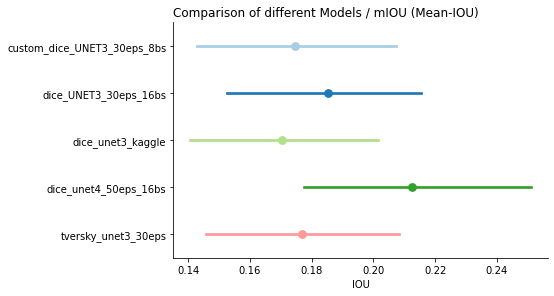

In [48]:
p = sns.catplot(data=df_score, x='iou', y='nn', hue='nn', legend=False,
            kind='point', palette='Paired', aspect=2, ci=95, height=4)
p.set_xlabels('IOU')
p.set_ylabels('')
plt.title('Comparison of different Models / mIOU (Mean-IOU)', loc='left')
plt.show()

**Comment:**

This plots shows a comparisson between the different model, which have been trained on the dataset. As visible the performance of the Unet4 which was trained on 50 epochs and on a larger batch size performed best, but the deviations are not significant to the other models. Here we can also see that the model with the custom loss function (`custom_dice_UNET3_30eps_8bs`) delivered a better median performance than one other model. As seen before with the histogram of IoU for a single model we have a lot of zero values including all images without a masks which pulls the median of the scores towards lower values.

## IoU-Thresholding over Pixels

In [49]:
def get_prediction_threshold(y_true: torch.Tensor, iou: list, threshold: float):
    """Returns prediction given an IOU-Threshold."""
    true_values, predictions = [], []    
    for i in range(len(y_true)):
        # predictions
        if iou[i] >= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
            
        # ground truth if sum bigger than it has at least a segment
        # mask indicating a tumor
        if (y_true[i] == 1).sum().item() > 0:
            true_values.append(1)
        else:
            true_values.append(0)
    return true_values, predictions

In [50]:
DO_THRESHOLDING = False

if DO_THRESHOLDING:
    threshold_metric = {}
    for path in tqdm(all_eval_files):
        model_name = path.split('/')[-1].split('.')[0]
        y_true, y_pred = torch.load(path)
        y_pred = torch.where(y_pred >= .5, 1, 0)
        score = []
        # calculate IOU values
        for i in range(y_pred.shape[0]):
            iter_score = intersection_over_union(A=y_true[i], B=y_pred[i], from_np_array=False)
            score.append(iter_score)

        # do tresholding over IOU
        res = []
        threshold_metric[model_name] = {}
        for t in np.arange(0, 1, .05):
            true, pred = get_prediction_threshold(y_true, score, t)
            # calc metric
            threshold_metric[model_name][t] = (precision_score(y_true=true, y_pred=pred, zero_division=0), 
                                               recall_score(y_true=true, y_pred=pred, zero_division=0))

  0%|          | 0/5 [00:00<?, ?it/s]

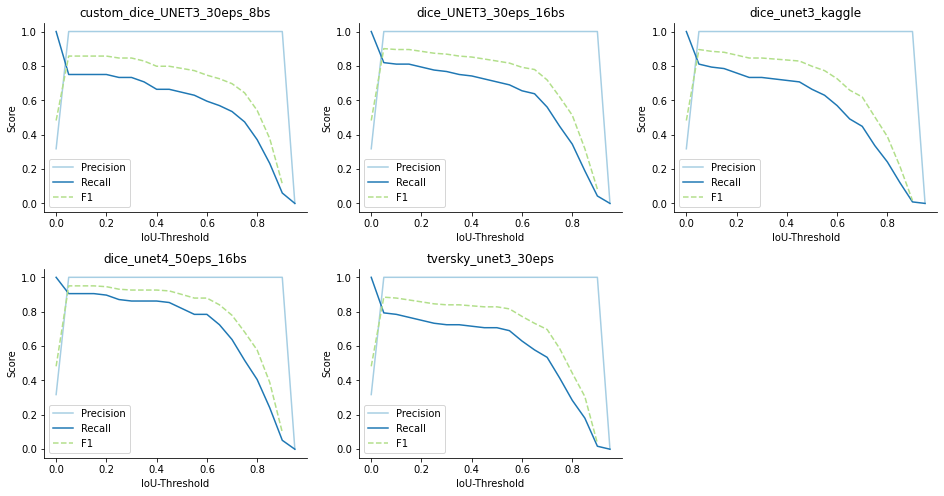

In [51]:
ncols = 3
nrows = int(np.ceil(len(threshold_metric) / ncols))
fig, ax = plt.subplots(figsize=(16, nrows*4))
sns.set_palette('Paired')
for i, k in enumerate(threshold_metric.keys()):
    tmp = pd.DataFrame(threshold_metric[k]).T
    tmp = tmp.reset_index()
    tmp.columns = ['threshold', 'precision', 'recall']
    tmp['f1'] = (2 * tmp['precision'] * tmp['recall']) / (tmp['precision'] + tmp['recall'])
    plt.subplot(nrows, ncols, i+1)
    p = sns.lineplot(x=tmp['threshold'], y=tmp['precision'], label='Precision')
    p = sns.lineplot(x=tmp['threshold'], y=tmp['recall'], label='Recall')
    p = sns.lineplot(x=tmp['threshold'], y=tmp['f1'], label='F1', linestyle='--')
    p.set_title(f'{k}')
    p.set_xlabel('IoU-Threshold')
    p.set_ylabel('Score')
    sns.despine()
plt.subplots_adjust(hspace=.3)
plt.show()

**Comment:**

Here we can see the course of Precision, Recall and F1 for each model. The plots look fairly similar to each other with regard to the shape of the curve. Along the increasing IoU-Threshold the Precision goes up to one, which indicates very less FP's. the recall score decreases over bigger IoU-Thresholds, which indicates that the fraction of the False Negative predicted is very dependent on the given threshold value.

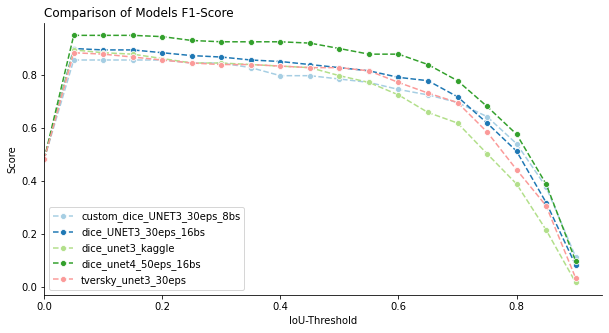

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set_palette('Paired')

for i, k in enumerate(threshold_metric.keys()):
    tmp = pd.DataFrame(threshold_metric[k]).T
    tmp = tmp.reset_index()
    tmp.columns = ['threshold', 'precision', 'recall']
    tmp['f1'] = (2 * tmp['precision'] * tmp['recall']) / (tmp['precision'] + tmp['recall'])
    p = sns.lineplot(x=tmp['threshold'], y=tmp['f1'], label=k, marker='o', linestyle='--')
p.set_title('Comparison of Models F1-Score', loc='left')
p.set_xlim(0)
p.set_xlabel('IoU-Threshold')
p.set_ylabel('Score')
sns.despine()
plt.subplots_adjust(hspace=.3)
plt.show()

**Comment:**

With this plot we compare all models with respect to the F1-score with each other. All models behave equally, as we have already seen in the plot above. The best Score was achieved for the UNet trained on 50 epochs and dice-loss on a threhsold of 0.05. In this plot we can also see, that the model which was trained on the custom loss better performs if a higher threshold values is given.

## Confusion Matrix

In [53]:
with open(all_eval_files[-2], 'rb') as file:
    true, pred = torch.load(file)

In [54]:
score = []
for i in range(true.shape[0]):
    iter_score = intersection_over_union(A=true[i], B=pred[i], from_np_array=False)
    score.append(iter_score)

In [55]:
true, pred = get_prediction_threshold(y_true, score, .05)

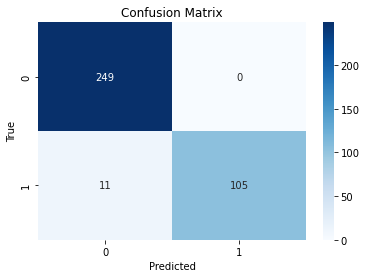

In [56]:
p = sns.heatmap(confusion_matrix(true, pred), cmap='Blues', fmt='d', annot=True)
p.set_title('Confusion Matrix')
p.set_ylabel('True')
p.set_xlabel('Predicted')
plt.show()

The confusion matrix shows the predicted values vs. the true values. As we can see that our model performs very well with regard to the FP and the truth positive as the ratio is very small for them. On the other hand we have 11 images of patient which have not been detected by our model.

In [57]:
wrong_predicted_idx = np.argwhere(np.array(true) != np.array(pred)).flatten()

In [58]:
imgs = [transforms.ToPILImage()(img) for img in y_true[wrong_predicted_idx]]

In [59]:
wrong_predicted = test.loc[wrong_predicted_idx].reset_index()
wrong_predicted.head(2)

,index,identifier,image,mask,patient_key,has_segment_mask,set,class_weight
0,29,TCGA_DU_7298_19910324_8,TCGA_DU_7298_19910324_8.tif,TCGA_DU_7298_19910324_8_mask.tif,TCGA_DU_7298,True,test,1.430808
1,52,TCGA_DU_7019_19940908_12,TCGA_DU_7019_19940908_12.tif,TCGA_DU_7019_19940908_12_mask.tif,TCGA_DU_7019,True,test,1.430808


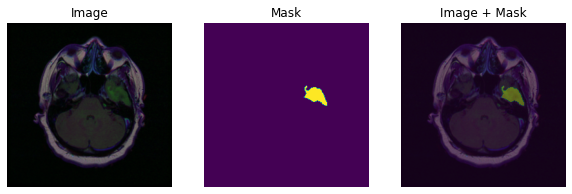

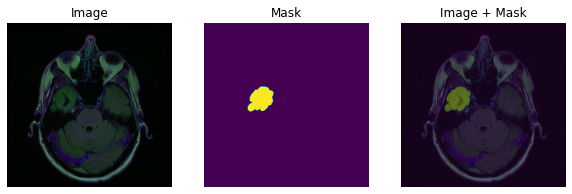

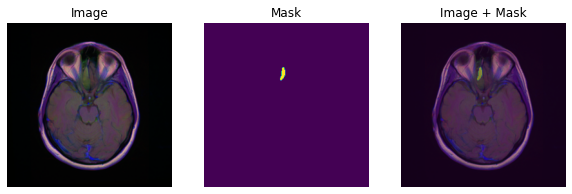

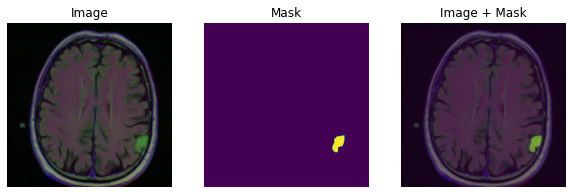

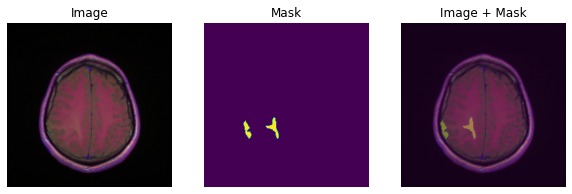

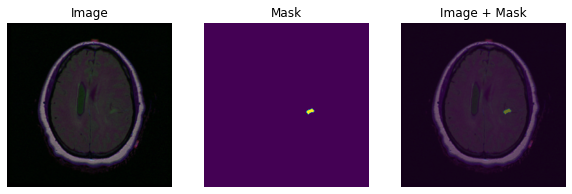

In [60]:
for i in range(len(wrong_predicted[:6])):
    plot_one_image_mask(wrong_predicted, wrong_predicted.loc[i, 'image'])

**Comment:**

The image show a sample of not found image mask within the dataset. As observable, there are some tumors which are either small or have a more complex shape.

## A closer look on wrong predicted masks

In [69]:
wrong_predicted

,index,identifier,image,mask,patient_key,has_segment_mask,set,class_weight
0,29,TCGA_DU_7298_19910324_8,TCGA_DU_7298_19910324_8.tif,TCGA_DU_7298_19910324_8_mask.tif,TCGA_DU_7298,True,test,1.430808
1,52,TCGA_DU_7019_19940908_12,TCGA_DU_7019_19940908_12.tif,TCGA_DU_7019_19940908_12_mask.tif,TCGA_DU_7019,True,test,1.430808
2,152,TCGA_HT_7874_19950902_8,TCGA_HT_7874_19950902_8.tif,TCGA_HT_7874_19950902_8_mask.tif,TCGA_HT_7874,True,test,1.430808
3,210,TCGA_FG_5964_20010511_17,TCGA_FG_5964_20010511_17.tif,TCGA_FG_5964_20010511_17_mask.tif,TCGA_FG_5964,True,test,1.430808
4,217,TCGA_HT_7473_19970826_24,TCGA_HT_7473_19970826_24.tif,TCGA_HT_7473_19970826_24_mask.tif,TCGA_HT_7473,True,test,1.430808
5,225,TCGA_DU_7298_19910324_20,TCGA_DU_7298_19910324_20.tif,TCGA_DU_7298_19910324_20_mask.tif,TCGA_DU_7298,True,test,1.430808
6,233,TCGA_DU_8163_19961119_14,TCGA_DU_8163_19961119_14.tif,TCGA_DU_8163_19961119_14_mask.tif,TCGA_DU_8163,True,test,1.430808
7,277,TCGA_DU_8162_19961029_11,TCGA_DU_8162_19961029_11.tif,TCGA_DU_8162_19961029_11_mask.tif,TCGA_DU_8162,True,test,1.430808
8,281,TCGA_DU_7300_19910814_13,TCGA_DU_7300_19910814_13.tif,TCGA_DU_7300_19910814_13_mask.tif,TCGA_DU_7300,True,test,1.430808
9,335,TCGA_DU_6400_19830518_16,TCGA_DU_6400_19830518_16.tif,TCGA_DU_6400_19830518_16_mask.tif,TCGA_DU_6400,True,test,1.430808


In [107]:
selected_idx = np.array([ 29, 52, 152, 210, 217, 225, 233, 277, 281, 335, 339])

In [108]:
def plot_models_predicted_masks(all_models: list, wrong_predicted: pd.DataFrame, selected_idx: int,
                                image_path = './kaggle_3m/images/', mask_path = './kaggle_3m/masks/'):
    # load from path
    image_path = './kaggle_3m/images/'
    mask_path = './kaggle_3m/masks/'
    one_sample = wrong_predicted.loc[wrong_predicted['index'].isin([selected_idx])]
    image = PIL.Image.open(os.path.join(image_path, one_sample['image'].values[0]))
    true_mask = PIL.Image.open(os.path.join(mask_path, one_sample['mask'].values[0]))
    
    # load and predict
    predicted_masks = []
    for i, path in enumerate(all_models, 2):
        interface = ModelInterface(model=torch.load(path, map_location='cpu'), name='Unet')
        predicted_mask = interface.segment_image(image=transforms.ToTensor()(image).unsqueeze(0))
        predicted_masks.append(predicted_mask)
    
    # pre-processe examples
    predicted_masks = [transforms.functional.convert_image_dtype(m, torch.bool) for m in predicted_masks]
    predicted_masks = [transforms.functional.convert_image_dtype(m, torch.bool).squeeze(0) for m in predicted_masks]
    predicted_masks = torch.cat(predicted_masks)
    true_mask = transforms.ToTensor()(true_mask)
    true_mask = true_mask.squeeze(0)
    
    draw_masks = []
    draw_masks.append(draw_segmentation_masks(transforms.functional.convert_image_dtype(transforms.ToTensor()(image), torch.uint8),
                                              true_mask.type(torch.bool), alpha=.8, colors='orange'))
    for mask in predicted_masks:
        seg_mask = draw_segmentation_masks(transforms.functional.convert_image_dtype(transforms.ToTensor()(image), torch.uint8),
                                masks=mask, alpha=.9, colors='yellow')
        draw_masks.append(seg_mask)

    show(draw_masks, figsize=(15, 4))

================================================== Selected ID:29 ==================================================


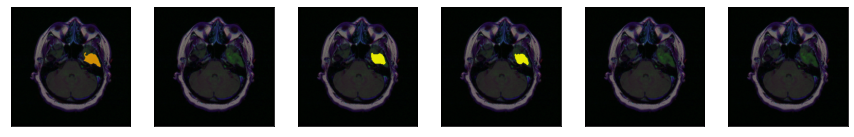

================================================== Selected ID:52 ==================================================


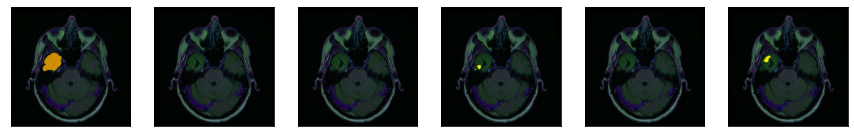

================================================== Selected ID:152 ==================================================


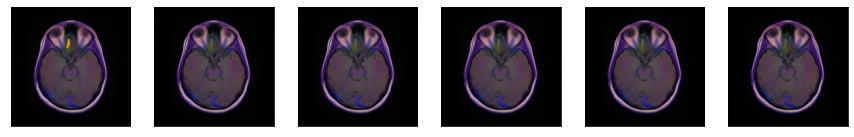

================================================== Selected ID:210 ==================================================


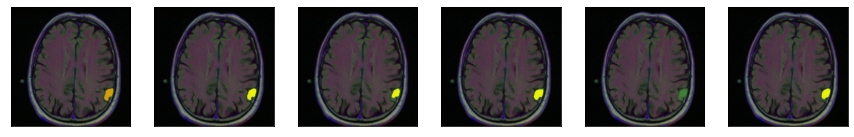

================================================== Selected ID:217 ==================================================


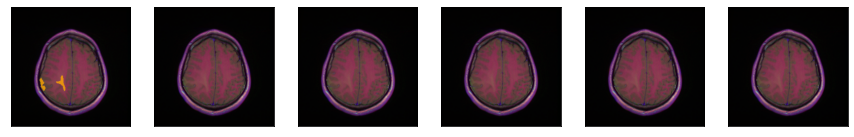

================================================== Selected ID:225 ==================================================


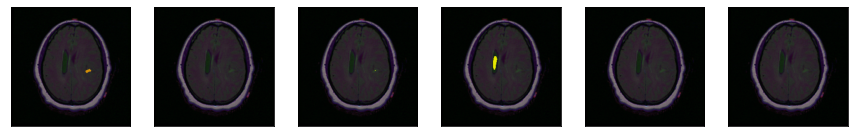

================================================== Selected ID:233 ==================================================


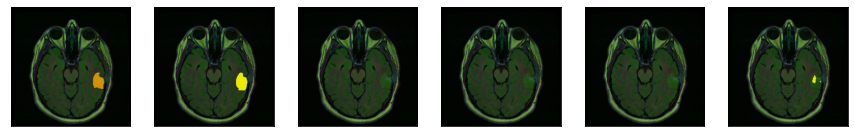

================================================== Selected ID:277 ==================================================


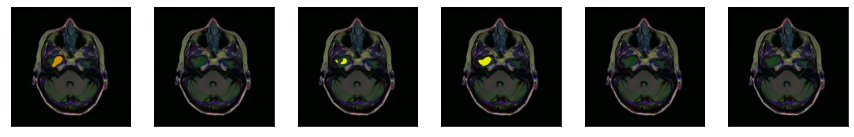

================================================== Selected ID:281 ==================================================


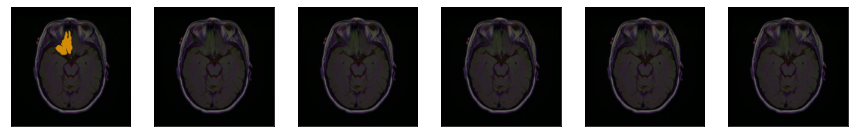

================================================== Selected ID:335 ==================================================


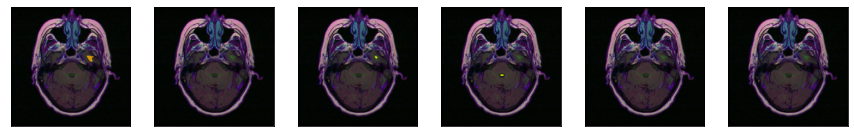

================================================== Selected ID:339 ==================================================


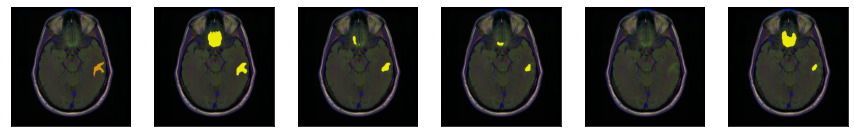

In [113]:
for idx in selected_idx:
    print(50*'=', f'Selected ID:{idx}', 50*'=')
    plot_models_predicted_masks(all_models=all_models, 
                                wrong_predicted=wrong_predicted, 
                                selected_idx=idx)

In [112]:
# show as help
dict(enumerate(all_models))

{0: './models/custom_dice_UNET3_30eps_8bs.pth',
 1: './models/dice_UNET3_30eps_16bs.pth',
 2: './models/dice_unet3_kaggle.pth',
 3: './models/dice_unet4_50eps_16bs.pth',
 4: './models/tversky_unet3_30eps.pth'}

**Comment**:

The left image shows the original mask (mask in orange color), whereas all the other image show the predicted masks from the different models (yellow color). It is very volatile depending on a the tested input image. Generally all models performed poorly on the images 152, 217, 225, 281, 335. These masks are either very small other have a complex shape. As I am no tumour specialist I can not tell, that I would see the respective tumour, which makes it hard to interpret the results of the models.
One pre-processing which could have been beneficial for the image would be the Normalization of all color channels as the images differ in color to each other. This could also be done by using only greyscale image, but with this procedure one would loose additional information about the image.

## Sources

Cubuk, E. D., Zoph, B., Shlens, J., & Le, Q. V. (2019). RandAugment: Practical automated data augmentation with a reduced search space (arXiv:1909.13719). arXiv. https://doi.org/10.48550/arXiv.1909.13719

Deyang. (o. J.). Based on the loss function PyTorch—Code World. Abgerufen 30. Mai 2022, von https://www.codetd.com/en/article/9915075

Eaton-Rosen, Z., Bragman, F., Ourselin, S., & Cardoso, M. J. (o. J.). Improving Data Augmentation for Medical Image Segmentation. 3.
Image-segmentation. (o. J.). Abgerufen 15. Juni 2022, von https://kaggle.com/simonstaehli/image-segmentation

Jordan, J. (2018, Mai 30). Evaluating image segmentation models. Jeremy Jordan. https://www.jeremyjordan.me/evaluating-image-segmentation-models/

Mwiti. (2020, April 7). Image Segmentation: Tips and Tricks from 39 Kaggle Competitions | Neptune Blog. Neptune.Ai. https://neptune.ai/blog/image-segmentation-tips-and-tricks-from-kaggle-competitions

Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation (arXiv:1505.04597). arXiv. https://doi.org/10.48550/arXiv.1505.04597

Sklearn.utils.class_weight.compute_class_weight. (o. J.). Scikit-Learn. Abgerufen 30. Mai 2022, von https://scikit-learn/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

Sugino, Kawase, Onogi, Kin, & Saito. (2021, Juli 26). Loss Weightings for Improving Imbalanced Brain Structure Segmentation Using Fully Convolutional Networks—PubMed. https://pubmed.ncbi.nlm.nih.gov/34442075/

Vinod, R. (2020, Juli 3). Dealing with class imbalanced image datasets using the Focal Tversky Loss. Medium. https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5

Yeung, M., Sala, E., Schönlieb, C.-B., & Rundo, L. (2022). Unified Focal loss: Generalising Dice and cross entropy-based losses to handle class imbalanced medical image segmentation. Computerized Medical Imaging and Graphics, 95, 102026. https://doi.org/10.1016/j.compmedimag.2021.102026

